# **Convert Scorecard**

Credit Scoring and Analytics

**References & Bibliography**: 
1. Siddiqi, N., 2017. *Intelligent Credit Scoring*. 2nd ed. US: Wiley.
2. Anderson, R., 2007. *The Credit Scoring Toolking*. 1st ed. Oxford: Oxford University Press.
3. Finlay, S., 2012. *Credit Scoring, Response Modelling and Insurance Rating*. 1st ed. US: Palgrave Macmillan.
4. Cohen, J., et al., 2003. *Applied multiple regression/correlation analysis for the behavioral sciences*. 2nd ed. New Jersey: Lawrence Erlbaum Associates.

---
**Outline**

1. Data Preparation
2. Data Exploration
3. Initial Characteristic Analysis
4. Design Scorecards
5. Scaling

In [1]:
# Load data manipulation package
import numpy as np
import pandas as pd

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# **1. Data Preparation**
---

## **1.1 Load Data**
---

The sample we will use in this example is a fictive dataset from [here](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).

The sample consist of some demographic, bureau, and financial information.

Note that we are not defining the default or bad status from our dataset here. Instead, we already have the binary response variable:

- `loan_status`
  - `loan_status = 0` for non default loan.
  - `loan_status = 1` for default loan.

The potential predictors for predicting the response variable are:

1. `person age` : age of the debtor.
2. `person_income` : annual income of the debtor.
3. `person_home_ownership`
  - `RENT`
  - `MORTGAGE`
  - `OWN`
  - `OTHER`
4. `person_emp_length` : employment length of debtor (in years).
5. `loan_intent` : purpose of the loan.
  - `EDUCATION`
  - `MEDICAL`
  - `VENTURE`
  - `PERSONAL`
  - `DEBTCONSOLIDATION`
6. `loan_grade`
7.  `loan_amnt`	: amount of the loan.
8. `loan_int_rate` : interest rate of the loan.
10. `loan_percent_income`	: percent loan of the debtor's income.
11. `cb_person_default_on_file`	: historical default.
  - `0` : the debtor does not have any history of defaults.
  - `1` : the debtor has a history of defaults on their credit file.
12. `cb_preson_cred_hist_length` : length of the credit history.

First, load the data from `credit_risk_dataset.csv` file.

In [2]:
# Import dataset from csv file
data = pd.read_csv('../data/credit_risk_dataset.csv')

# Table check
data.head().T

,0,1,2,3,4
person_age,22,21,25,23,24
person_income,59000,9600,9600,65500,54400
person_home_ownership,RENT,OWN,MORTGAGE,RENT,RENT
person_emp_length,123.0,5.0,1.0,4.0,8.0
loan_intent,PERSONAL,EDUCATION,MEDICAL,MEDICAL,MEDICAL
loan_grade,D,B,C,C,C
loan_amnt,35000,1000,5500,35000,35000
loan_int_rate,16.02,11.14,12.87,15.23,14.27
loan_status,1,0,1,1,1
loan_percent_income,0.59,0.1,0.57,0.53,0.55


Check the data shape.
- How many variables are there?

In [3]:
# Check the data shape
data.shape

(32581, 12)

Our sample contains 12 variables from 32,581 credit records.
- 1 response variable, `loan_status`,
- and 11 potential predictors/characteristics.

Before modeling, make sure you split the data first for model validation.

In the classification case, check the proportion of response variable first to decide the splitting strategy.

In [4]:
# Define response variable
response_variable = 'loan_status'

# Check the proportion of response variable
data[response_variable].value_counts(normalize = True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

The proportion of the response variable, `loan status`, is not quite balanced (in a ratio of 78:22).

To get the same ratio in training and testing set, define a stratified splitting based on the response variable, `loan_status`.

## **1.2 Sample Splitting**
---

First, define the predictors (X) and the response (y).

In [5]:
# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (32581,)
X shape : (32581, 11)


Next, split the training and testing set from each predictors (X) and response (y).
- Set `stratify = y` for splitting the sample with stratify, based on the proportion of response y.
- Set `test_size = 0.3` for holding 30% of the sample as a testing set.
- Set `random_state = 42` for reproducibility.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (22806, 11)
y train shape : (22806,)
X test shape  : (9775, 11)
y test shape  : (9775,)


Check the proportion of response y in each training and testing set.

In [7]:
y_train.value_counts(normalize = True)

loan_status
0    0.781856
1    0.218144
Name: proportion, dtype: float64

In [8]:
y_test.value_counts(normalize = True)

loan_status
0    0.78179
1    0.21821
Name: proportion, dtype: float64

# **2. Data Exploration**
---

## **2.1 Exploratory Data Analysis (EDA)**

- To make a model that predicts well on unseen data, we must prevent leakage of test set information.
- Thus, we only explore on **training set**.

In [9]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train),
                       axis = 1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (22806, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
11491,26,62000,RENT,1.0,DEBTCONSOLIDATION,B,10000,11.26,0.16,N,2,0
3890,23,39000,MORTGAGE,3.0,EDUCATION,C,5000,12.98,0.13,N,4,0
17344,24,35000,RENT,1.0,DEBTCONSOLIDATION,A,12000,6.54,0.34,N,2,1
13023,24,86000,RENT,1.0,HOMEIMPROVEMENT,B,12000,10.65,0.14,N,3,0
29565,42,38400,RENT,4.0,MEDICAL,B,13000,NaN,0.34,N,11,1


What do we do in EDA?
- Check data integrity.
- Check for any insight in the data: distribution, proportion, outliers, missing values, etc.
- Make a plan for data pre-processing.

### Check for Missing Values
---

In [10]:
# Check for missing values
data_train.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              639
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2200
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [11]:
# Check for data type
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22806 entries, 11491 to 10456
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  22806 non-null  int64  
 1   person_income               22806 non-null  int64  
 2   person_home_ownership       22806 non-null  object 
 3   person_emp_length           22167 non-null  float64
 4   loan_intent                 22806 non-null  object 
 5   loan_grade                  22806 non-null  object 
 6   loan_amnt                   22806 non-null  int64  
 7   loan_int_rate               20606 non-null  float64
 8   loan_percent_income         22806 non-null  float64
 9   cb_person_default_on_file   22806 non-null  object 
 10  cb_person_cred_hist_length  22806 non-null  int64  
 11  loan_status                 22806 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.3+ MB


**Summary**
- There are missing values in `person_emp_length`, a numerical/float variable and `loan_int_rate`, a categorical variable.
- We need to find how to handle the missing values by exploring the variables.

## **2.2 Check Correlation**
---

We'll calculate the Pearson correlation between numerical predictors to see whether we have multicollinearity in training set.

First, define the list of numerical and categorical predictors.

### Define Numerical and Categorical Predictors
---

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22806 entries, 11491 to 10456
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  22806 non-null  int64  
 1   person_income               22806 non-null  int64  
 2   person_home_ownership       22806 non-null  object 
 3   person_emp_length           22167 non-null  float64
 4   loan_intent                 22806 non-null  object 
 5   loan_grade                  22806 non-null  object 
 6   loan_amnt                   22806 non-null  int64  
 7   loan_int_rate               20606 non-null  float64
 8   loan_percent_income         22806 non-null  float64
 9   cb_person_default_on_file   22806 non-null  object 
 10  cb_person_cred_hist_length  22806 non-null  int64  
 11  loan_status                 22806 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.3+ MB


In [13]:
# Define data with numerical predictors
num_columns = ['person_age',
               'person_income',
               'person_emp_length',
               'loan_amnt',
               'loan_int_rate',
               'loan_percent_income',
               'cb_person_cred_hist_length']

# Define data with categorical predictors
cat_columns = ['person_home_ownership',
               'loan_intent',
               'loan_grade',
               'cb_person_default_on_file']

### Check Multicollinearity
---
Next, calculate the Pearson correlation coefficient between numerical predictors.

In [14]:
# Calculate Pearson correlation coefficient from numerical predictors
data_train_corr = data_train[num_columns].corr(method = 'pearson')

data_train_corr

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.190499,0.171397,0.054560,0.014319,-0.045562,0.859739
person_income,0.190499,1.000000,0.138115,0.263430,0.001691,-0.248180,0.119455
person_emp_length,0.171397,0.138115,1.000000,0.113166,-0.057092,-0.055841,0.155085
loan_amnt,0.054560,0.263430,0.113166,1.000000,0.140190,0.570820,0.047096
loan_int_rate,0.014319,0.001691,-0.057092,0.140190,1.000000,0.114287,0.018522
loan_percent_income,-0.045562,-0.248180,-0.055841,0.570820,0.114287,1.000000,-0.031308
cb_person_cred_hist_length,0.859739,0.119455,0.155085,0.047096,0.018522,-0.031308,1.000000


<Axes: >

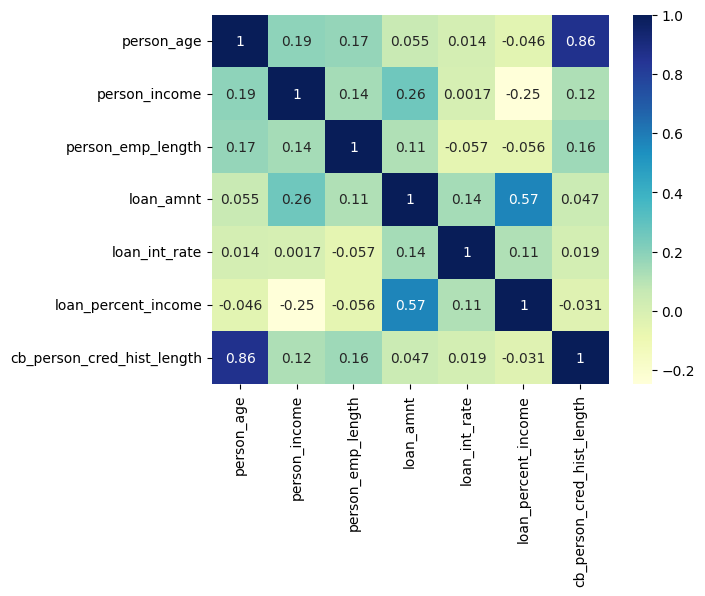

In [15]:
# Plot the heatmap correlation
sns.heatmap(data = data_train_corr,
            cmap = "YlGnBu",
            annot = True)

We may have multicollinearity between `person_age` and `cb_person_cred_hist_length`.
- We will perform model selection or
- Exclude `cb_person_cred_hist_length`.



# **3. Initial Characteristic Analysis**
---

We know from EDA that we have missing values in numerical predictors `person_emp_length` and `loan_int_rate`.

Here, we will group the missing values in each predictor to retain the sample's information as it is.

### **3.1 Characteristic Binning**
---

Create a function for binning the numerical predictors.

In [16]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning numerical predictor.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    num_of_bins : integer
      The number of bins.


    Return
    ------
    data : array like
      The name of transformed dataset.

    """
    # Create a new column containing the binned predictor
    data[predictor_label + "_bin"] = pd.qcut(data[predictor_label],
                                             q = num_of_bins)

    return data

In [17]:
for column in num_columns:
  data_train_binned = create_binning(data = data_train,
                                     predictor_label = column,
                                     num_of_bins = 4)

In [18]:
data_train_binned.T

,11491,3890,17344,13023,29565,22677,25029,23700,4299,29314,...,21156,24380,30751,31368,1376,22095,18736,1663,18257,10456
person_age,26,23,24,24,42,30,27,28,23,39,...,27,27,43,37,22,32,30,22,29,22
person_income,62000,39000,35000,86000,38400,46800,80000,62000,46500,65000,...,45000,72000,54000,44196,35100,38000,65000,20000,110000,30000
person_home_ownership,RENT,MORTGAGE,RENT,RENT,RENT,RENT,MORTGAGE,RENT,RENT,RENT,...,MORTGAGE,MORTGAGE,RENT,RENT,RENT,RENT,RENT,RENT,RENT,RENT
person_emp_length,1.0,3.0,1.0,1.0,4.0,0.0,11.0,3.0,3.0,12.0,...,9.0,6.0,0.0,0.0,0.0,3.0,0.0,7.0,4.0,6.0
loan_intent,DEBTCONSOLIDATION,EDUCATION,DEBTCONSOLIDATION,HOMEIMPROVEMENT,MEDICAL,EDUCATION,EDUCATION,MEDICAL,EDUCATION,VENTURE,...,MEDICAL,EDUCATION,EDUCATION,MEDICAL,DEBTCONSOLIDATION,VENTURE,MEDICAL,EDUCATION,HOMEIMPROVEMENT,DEBTCONSOLIDATION
loan_grade,B,C,A,B,B,A,B,B,D,B,...,B,A,A,B,C,A,C,A,E,B
loan_amnt,10000,5000,12000,12000,13000,7500,7500,9200,4600,20000,...,12000,6000,8725,12400,1000,6350,16000,1675,24000,10000
loan_int_rate,11.26,12.98,6.54,10.65,NaN,7.88,11.71,10.0,NaN,10.74,...,9.76,5.42,7.29,11.26,13.98,5.79,13.06,7.74,18.39,10.37
loan_percent_income,0.16,0.13,0.34,0.14,0.34,0.16,0.09,0.15,0.1,0.31,...,0.27,0.08,0.16,0.28,0.03,0.17,0.25,0.08,0.22,0.33
cb_person_default_on_file,N,N,N,N,N,N,N,N,Y,N,...,N,N,N,N,N,N,N,N,Y,N


#### Missing Values Binning

Remember we have missing values in some numerical predictors.

Here we will group the missing values.

In [19]:
# Check for missing values
data_train_binned.isna().sum()

person_age                           0
person_income                        0
person_home_ownership                0
person_emp_length                  639
loan_intent                          0
loan_grade                           0
loan_amnt                            0
loan_int_rate                     2200
loan_percent_income                  0
cb_person_default_on_file            0
cb_person_cred_hist_length           0
loan_status                          0
person_age_bin                       0
person_income_bin                    0
person_emp_length_bin              639
loan_amnt_bin                        0
loan_int_rate_bin                 2200
loan_percent_income_bin              0
cb_person_cred_hist_length_bin       0
dtype: int64

Create a function for binning missing values separately.


In [20]:
# # Define columns with missing values
# missing_columns = ['person_emp_length_bin',
#                    'loan_int_rate_bin',
#                    'cb_person_cred_hist_length_bin']

# Define columns with missing values
missing_columns = ['person_emp_length_bin',
                   'loan_int_rate_bin']

In [21]:
# Perform grouping for all columns
for column in missing_columns:

  # Add category 'Missing' to replace the missing values
  data_train_binned[column] = data_train_binned[column].cat.add_categories('Missing')

  # Replace missing values with category 'Missing'
  data_train_binned[column].fillna(value = 'Missing',
                                   inplace = True)

/tmp/ipykernel_88400/1887443061.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train_binned[column].fillna(value = 'Missing',


In [22]:
# Sanity check
data_train_binned.isna().sum()

person_age                           0
person_income                        0
person_home_ownership                0
person_emp_length                  639
loan_intent                          0
loan_grade                           0
loan_amnt                            0
loan_int_rate                     2200
loan_percent_income                  0
cb_person_default_on_file            0
cb_person_cred_hist_length           0
loan_status                          0
person_age_bin                       0
person_income_bin                    0
person_emp_length_bin                0
loan_amnt_bin                        0
loan_int_rate_bin                    0
loan_percent_income_bin              0
cb_person_cred_hist_length_bin       0
dtype: int64

### **3.2 WoE and IV**
---  
To assess the strength of each characteristic individually as a predictor of the credit performance.

First, create a contingency table/crosstab for all predictors: numerical and categorical predictors.

In [23]:
# Define the initial empty list
crosstab_num = []

for column in num_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column + "_bin"],
                         data_train_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_num.append(crosstab)

In [24]:
# Define the initial empty list
crosstab_cat = []

for column in cat_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column],
                         data_train_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_cat.append(crosstab)

In [25]:
# Put all two in a crosstab_list
crosstab_list = crosstab_num + crosstab_cat

crosstab_list

[loan_status         0     1    All
 person_age_bin                    
 (19.999, 23.0]   4671  1469   6140
 (23.0, 26.0]     5007  1361   6368
 (26.0, 30.0]     3856  1026   4882
 (30.0, 144.0]    4297  1119   5416
 All             17831  4975  22806,
 loan_status               0     1    All
 person_income_bin                       
 (3999.999, 38524.75]   3433  2269   5702
 (38524.75, 55000.0]    4483  1221   5704
 (55000.0, 79635.0]     4731   967   5698
 (79635.0, 6000000.0]   5184   518   5702
 All                   17831  4975  22806,
 loan_status                0     1    All
 person_emp_length_bin                    
 (-0.001, 2.0]           5533  2051   7584
 (2.0, 4.0]              3510   917   4427
 (4.0, 7.0]              4460  1023   5483
 (7.0, 123.0]            3885   788   4673
 Missing                  443   196    639
 All                    17831  4975  22806,
 loan_status             0     1    All
 loan_amnt_bin                         
 (499.999, 5000.0]    5257 

Next, calculate the WOE and IV for each crosstab.

- Weight of Evidence (WoE) — measures the strength of each attribute.

$$
\begin{align*}
W_i &= \ln ( \% \text{Good} / \% \text{Bad} ) \\
W_i &= \ln \left ( \left ( \frac{N_i}{\sum N} \right ) / \left ( \frac{P_i}{\sum P} \right )\right ) \\
\end{align*}
$$

- Information Value (IV) — measures the total strength of the characteristic.

$$
\begin{align*}
IV &= \sum_{i=1}^{n} ( \% \text{Good} - \% \text{Bad} ) \times W_i \\
IV &= \sum_{i=1}^{n}\left [ \left ( \frac{N_i}{\sum N} - \frac{P_i}{\sum P} \right ) \times W_i \right ] \\
\end{align*}
$$

In [26]:
# Define the initial list for WOE
WOE_list = []

# Define the initial list for IV
IV_list = []

# Create the initial table for IV
IV_table = pd.DataFrame({'Characteristic': [],
                         'Information Value' : []})

# Perform the algorithm for all crosstab
for crosstab in crosstab_list:

  # Calculate % Good
  crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

  # Calculate % Bad
  crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

  # Calculate the WOE
  crosstab['WOE'] = np.log(crosstab['p_good']/crosstab['p_bad'])

  # Calculate the contribution value for IV
  crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

  # Calculate the IV
  IV = crosstab['contribution'][:-1].sum()

  add_IV = {'Characteristic': crosstab.index.name,
            'Information Value': IV}

  WOE_list.append(crosstab)
  IV_list.append(add_IV)

In [27]:
WOE_list

[loan_status         0     1    All    p_good     p_bad       WOE  contribution
 person_age_bin                                                                
 (19.999, 23.0]   4671  1469   6140  0.261960  0.295276 -0.119722      0.003989
 (23.0, 26.0]     5007  1361   6368  0.280803  0.273568  0.026104      0.000189
 (26.0, 30.0]     3856  1026   4882  0.216253  0.206231  0.047449      0.000476
 (30.0, 144.0]    4297  1119   5416  0.240985  0.224925  0.068969      0.001108
 All             17831  4975  22806  1.000000  1.000000  0.000000      0.000000,
 loan_status               0     1    All    p_good     p_bad       WOE  \
 person_income_bin                                                        
 (3999.999, 38524.75]   3433  2269   5702  0.192530  0.456080 -0.862418   
 (38524.75, 55000.0]    4483  1221   5704  0.251416  0.245427  0.024109   
 (55000.0, 79635.0]     4731   967   5698  0.265324  0.194372  0.311180   
 (79635.0, 6000000.0]   5184   518   5702  0.290730  0.104121  1

In [28]:
# Create initial table to summarize the WOE values
WOE_table = pd.DataFrame({'Characteristic': [],
                          'Attribute': [],
                          'WOE': []})

for i in range(len(crosstab_list)):

  # Define crosstab and reset index
  crosstab = crosstab_list[i].reset_index()

  # Save the characteristic name
  char_name = crosstab.columns[0]

  # Only use two columns (Attribute name and its WOE value)
  # Drop the last row (average/total WOE)
  crosstab = crosstab.iloc[:-1, [0,-2]]
  crosstab.columns = ['Attribute', 'WOE']

  # Add the characteristic name in a column
  crosstab['Characteristic'] = char_name

  WOE_table = pd.concat((WOE_table, crosstab),
                        axis = 0)

  # Reorder the column
  WOE_table.columns = ['Characteristic',
                       'Attribute',
                       'WOE']

WOE_table

,Characteristic,Attribute,WOE
0,person_age_bin,"(19.999, 23.0]",-0.119722
1,person_age_bin,"(23.0, 26.0]",0.026104
2,person_age_bin,"(26.0, 30.0]",0.047449
3,person_age_bin,"(30.0, 144.0]",0.068969
0,person_income_bin,"(3999.999, 38524.75]",-0.862418
1,person_income_bin,"(38524.75, 55000.0]",0.024109
2,person_income_bin,"(55000.0, 79635.0]",0.311180
3,person_income_bin,"(79635.0, 6000000.0]",1.026844
0,person_emp_length_bin,"(-0.001, 2.0]",-0.284110
1,person_emp_length_bin,"(2.0, 4.0]",0.065751


In [29]:
# Put all IV in the table
IV_table = pd.DataFrame(IV_list)
IV_table

,Characteristic,Information Value
0,person_age_bin,0.005761
1,person_income_bin,0.441132
2,person_emp_length_bin,0.064186
3,loan_amnt_bin,0.076986
4,loan_int_rate_bin,0.507604
5,loan_percent_income_bin,0.606650
6,cb_person_cred_hist_length_bin,0.003737
7,person_home_ownership,0.386431
8,loan_intent,0.088282
9,loan_grade,0.858398


The rule of thumb regarding IV:
- Less than 0.02 : generally unpredictive
- 0.02 to 0.1 : weak
- 0.1 to 0.3 : medium
- 0.3+ : strong

In [30]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in IV_table['Information Value']:
  if iv < 0.02:
    strength.append('Unpredictive')
  elif iv >= 0.02 and iv < 0.1:
    strength.append('Weak')
  elif iv >= 0.1 and iv < 0.3:
    strength.append('Medium')
  elif iv >= 0.3 and iv < 0.5:
    strength.append('Strong')
  else:
    strength.append('Very strong')

# Assign the strength to each characteristic
IV_table = IV_table.assign(Strength = strength)

# Sort the table by the IV values
IV_table.sort_values(by='Information Value')

,Characteristic,Information Value,Strength
6,cb_person_cred_hist_length_bin,0.003737,Unpredictive
0,person_age_bin,0.005761,Unpredictive
2,person_emp_length_bin,0.064186,Weak
3,loan_amnt_bin,0.076986,Weak
8,loan_intent,0.088282,Weak
10,cb_person_default_on_file,0.159914,Medium
7,person_home_ownership,0.386431,Strong
1,person_income_bin,0.441132,Strong
4,loan_int_rate_bin,0.507604,Very strong
5,loan_percent_income_bin,0.606650,Very strong


From the IV table:
- We have 2 unpredictive and 3 weak characteristics.
- Be careful for 3 very strong characteristics: should be checked for overpredicting.

Before performing model selection in modeling, we will check the independency between each characteristic with the response variable `loan_status`.

Before that, we'll check the logical trend and operational/business considerations from the WOE in each characteristic.

### **3.3 Check Logical Trend and Business Consideration**
---

In grouped scorecards, the attribute strengths must also be in a logical order, and make operational sense.

In [31]:
char_list = IV_table['Characteristic'].tolist()
char_list

['person_age_bin',
 'person_income_bin',
 'person_emp_length_bin',
 'loan_amnt_bin',
 'loan_int_rate_bin',
 'loan_percent_income_bin',
 'cb_person_cred_hist_length_bin',
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

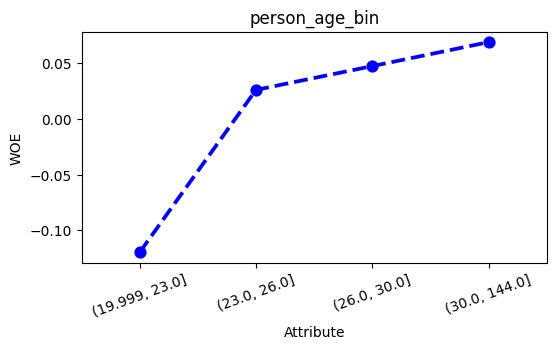

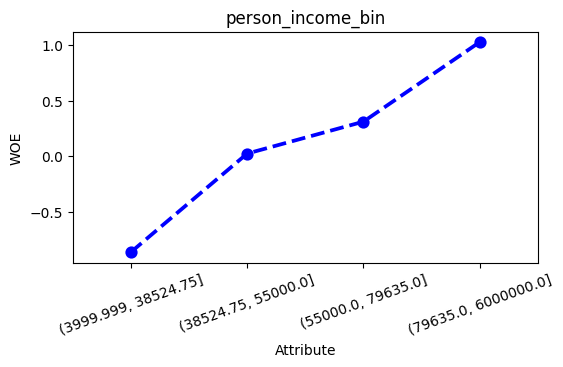

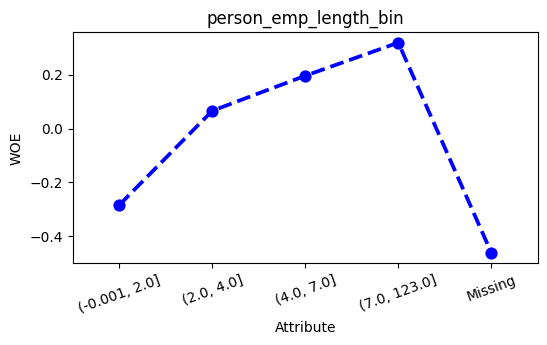

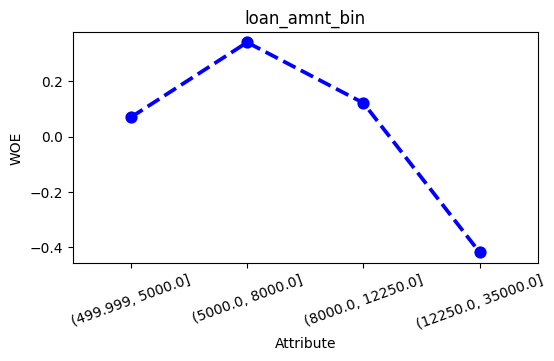

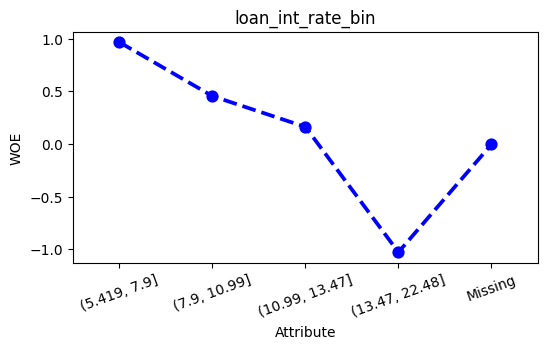

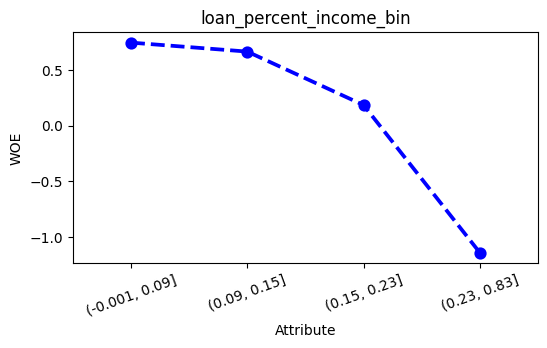

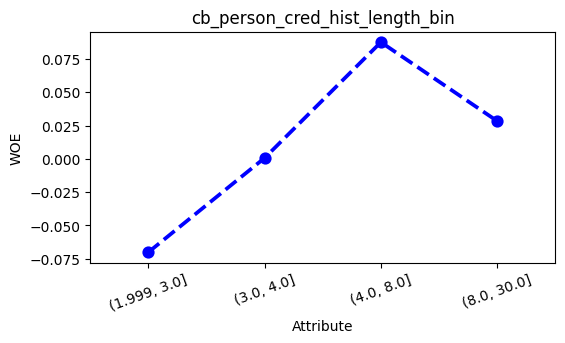

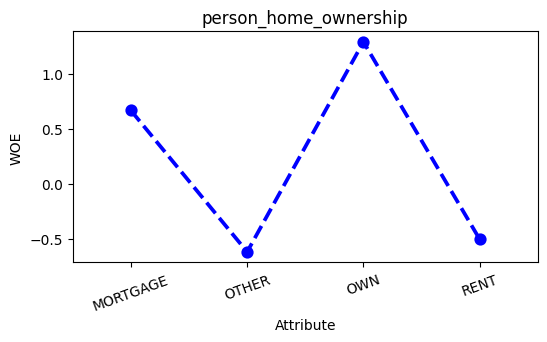

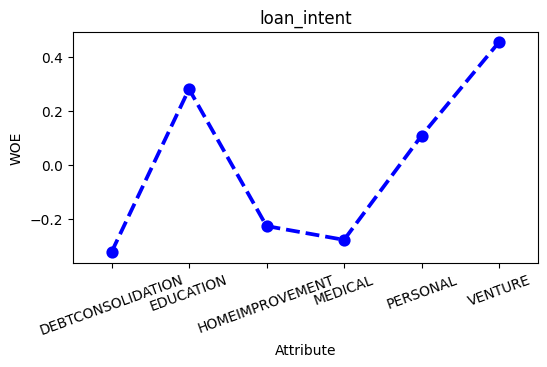

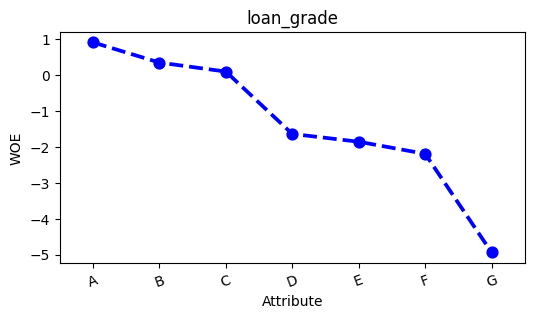

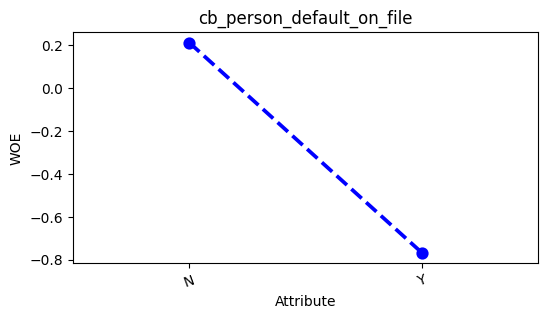

In [32]:
for char in char_list:

  crosstab = WOE_table[WOE_table['Characteristic'] == char]

  # Define the plot size and title
  plt.figure(figsize = (6,3))
  plt.title(char)

  # Plot the WOE
  sns.pointplot(x = crosstab['Attribute'],
                y = 'WOE',
                data = crosstab,
                markers = 'o',
                linestyles = '--',
                color = 'blue')

  # Rotate the label of x-axis
  plt.xticks(rotation = 20)

## **3.4 Test of Independence**
---

- Assume that the WOE for each attribute in all characteristics supports the logical trend and operational/business sense.
- Then, we can check the strength of each characteristic as a predictor of credit performance by its Information Value (IV).

In [33]:
# Display the IV Table
IV_table

,Characteristic,Information Value,Strength
0,person_age_bin,0.005761,Unpredictive
1,person_income_bin,0.441132,Strong
2,person_emp_length_bin,0.064186,Weak
3,loan_amnt_bin,0.076986,Weak
4,loan_int_rate_bin,0.507604,Very strong
5,loan_percent_income_bin,0.606650,Very strong
6,cb_person_cred_hist_length_bin,0.003737,Unpredictive
7,person_home_ownership,0.386431,Strong
8,loan_intent,0.088282,Weak
9,loan_grade,0.858398,Very strong


The predictive power of characteristics varies from unpredictive to strong.

Next, we check the dependency between each characteristic and the response variable `loan_status` before modeling.
- To check whether the unpredictive and weak characteristic is independent of the probability of default.

Create a funtion to perform independence test.

- **Null Hypothesis:** The characteristic and response variable is independent.
- **Alternative Hypothesis:** The characteristic and response variable is not independent.
- **Test Statistic:**
  - Pearson Chi-squared Statistic

  $$
  \chi ^{2}=\sum \frac{(n_{ij}-\mu _{ij})^{2}}{\mu _{ij}}
  $$
  where
  $$
  \mu _{ij}=\frac{(n_{i+})(n_{+j})}{n}
  $$

  - degrees of freedom = $(I-1) \times (J-1)$
- **Rejection Region:**

$$
\begin{align*}
\chi^{2} &> \chi^{2}_{\alpha} \\
&\text{or} \\
P_{\text{value}} &< \alpha
\end{align*}
$$


In [34]:
# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Create a function of independence test
def independence_test(data, characteristic_label, alpha=0.05):
    """
    Function to perform the independence test.

    Parameters
    ----------
    data : array like
      The name of dataset.

    characteristic_label : object
      The label of characteristic variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    Return
    ------
    res : dataframe
      The summary result of the independence test.

    """
    # Build the contingency table
    crosstab = pd.crosstab(data[characteristic_label],
                           data[response_variable],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        conclusion = 'Not Independent'
    else:
        conclusion = 'Independent'

    # Tabulate the results
    res = pd.DataFrame({'Characteristic': characteristic_label,
                        'Chi-stat': round(stat,2),
                        'P-value': pval,
                        'Conclusion': conclusion},
                       index = [0])

    return res

In [35]:
# Define initial table to summarize the test result
ind_table = pd.DataFrame({'Characteristic': [],
                        'Chi-stat': [],
                        'P-value': [],
                        'Conclusion': []})

# Perform independence test for all characteristics
for characteristic in char_list:

  # Perform the independence test
  test_result = independence_test(data = data_train_binned,
                                  characteristic_label = characteristic,
                                  alpha = 0.05)

  # # Append test result to the table
  ind_table = pd.concat((ind_table, test_result),
                        axis = 0,
                        ignore_index = True)

In [36]:
# Check the results
ind_table

,Characteristic,Chi-stat,P-value,Conclusion
0,person_age_bin,22.82,4.411133e-05,Not Independent
1,person_income_bin,1701.30,0.000000e+00,Not Independent
2,person_emp_length_bin,253.35,1.233544e-53,Not Independent
3,loan_amnt_bin,312.13,2.353494e-67,Not Independent
4,loan_int_rate_bin,2086.16,0.000000e+00,Not Independent
5,loan_percent_income_bin,2611.27,0.000000e+00,Not Independent
6,cb_person_cred_hist_length_bin,14.50,2.294776e-03,Not Independent
7,person_home_ownership,1362.16,4.790150e-295,Not Independent
8,loan_intent,335.51,2.306048e-70,Not Independent
9,loan_grade,3862.41,0.000000e+00,Not Independent


All characteristics are not independent of the response variable (probability of default).

# **4. Design Scorecards**
---

- To design the scorecards, we will use a logistic regression model.
- We will perform the logistic regression not against the original input, but rather against the WOE of each grouping created in the previous step.

Therefore, we will transform the training set into the WOE value of each attribute.

## **4.1 Pre-processing Training Set**
---

First, create a function to generate a dictionary for mapping WOE values.

In [37]:
# Function to generate the WOE mapping dictionary
def get_woe_map_dict(WOE_table):

    # Initialize the dictionary
    WOE_map_dict = {}
    WOE_map_dict['Missing'] = {}

    unique_char = set(WOE_table['Characteristic'])
    for char in unique_char:
        # Get the Attribute & WOE info for each characteristics
        current_data = (WOE_table
                            [WOE_table['Characteristic']==char]     # Filter based on characteristic
                            [['Attribute', 'WOE']])                 # Then select the attribute & WOE

        # Get the mapping
        WOE_map_dict[char] = {}
        for idx in current_data.index:
            attribute = current_data.loc[idx, 'Attribute']
            woe = current_data.loc[idx, 'WOE']

            if attribute == 'Missing':
                WOE_map_dict['Missing'][char] = woe
            else:
                WOE_map_dict[char][attribute] = woe
                WOE_map_dict['Missing'][char] = np.nan

    # Validate data
    print('Number of key : ', len(WOE_map_dict.keys()))

    return WOE_map_dict


In [38]:
# Generate the WOE map dictionary
WOE_map_dict = get_woe_map_dict(WOE_table = WOE_table)
WOE_map_dict

Number of key :  12


{'Missing': {'person_emp_length_bin': -0.4610580341267352,
  'loan_int_rate_bin': -0.005541156447753005,
  'loan_intent': nan,
  'person_age_bin': nan,
  'cb_person_default_on_file': nan,
  'loan_amnt_bin': nan,
  'cb_person_cred_hist_length_bin': nan,
  'person_home_ownership': nan,
  'loan_percent_income_bin': nan,
  'loan_grade': nan,
  'person_income_bin': nan},
 'person_emp_length_bin': {Interval(-0.001, 2.0, closed='right'): -0.2841104601156244,
  Interval(2.0, 4.0, closed='right'): 0.06575069926209322,
  Interval(4.0, 7.0, closed='right'): 0.19589613412112988,
  Interval(7.0, 123.0, closed='right'): 0.3188670280025152},
 'loan_int_rate_bin': {Interval(5.419, 7.9, closed='right'): 0.9658824346576351,
  Interval(7.9, 10.99, closed='right'): 0.4540603316153162,
  Interval(10.99, 13.47, closed='right'): 0.1614755688478184,
  Interval(13.47, 22.48, closed='right'): -1.0288613618161406},
 'loan_intent': {'DEBTCONSOLIDATION': -0.32386876087891786,
  'EDUCATION': 0.28176538673110774,
  

Next, we can transform the raw values in `X_train` into its WOE values.

In [39]:
# Function to replace the raw data in the train set with WOE values
def transform_woe(raw_data, WOE_dict, num_cols):

    woe_data = raw_data.copy()

    # Map the raw data
    for col in woe_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        woe_data[col] = woe_data[col].map(WOE_map_dict[map_col])

    # Map the raw data if there is a missing value or out of range value
    for col in woe_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        woe_data[col] = woe_data[col].fillna(value=WOE_map_dict['Missing'][map_col])

    return woe_data

In [40]:
# Transform the X_train
woe_train = transform_woe(raw_data = X_train,
                          WOE_dict = WOE_map_dict,
                          num_cols = num_columns)

woe_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
11491,0.026104,0.311180,-0.506161,-0.284110,-0.323869,0.343137,0.121353,0.161476,0.184567,0.211359,-0.070043
3890,-0.119722,0.024109,0.665394,0.065751,0.281765,0.092115,0.069698,0.161476,0.663435,0.211359,0.000751
17344,0.026104,-0.862418,-0.506161,-0.284110,-0.323869,0.904584,0.121353,0.965882,-1.137536,0.211359,-0.070043
13023,0.026104,1.026844,-0.506161,-0.284110,-0.227074,0.343137,0.121353,0.454060,0.663435,0.211359,-0.070043
29565,0.068969,-0.862418,-0.506161,0.065751,-0.278307,0.343137,-0.419296,-0.005541,-1.137536,0.211359,0.028436
...,...,...,...,...,...,...,...,...,...,...,...
22095,0.068969,-0.862418,-0.506161,0.065751,0.456230,0.904584,0.340733,0.965882,0.184567,0.211359,0.087637
18736,0.047449,0.311180,-0.506161,-0.284110,-0.278307,0.092115,-0.419296,0.161476,-1.137536,0.211359,0.087637
1663,-0.119722,-0.862418,-0.506161,0.195896,0.281765,0.904584,0.069698,0.965882,0.743839,0.211359,-0.070043
18257,0.047449,1.026844,-0.506161,0.065751,-0.227074,-1.860620,-0.419296,-1.028861,0.184567,-0.766741,0.087637


## **4.2 Pre-processing Testing Set**
---

We have to pre-process the test data according to the pre-processing pipeline in train data.

Therefore, we transform the raw `X_test` into the WOE values from the train set.

In [41]:
# Transform the X_test
woe_test = transform_woe(raw_data = X_test,
                         WOE_dict = WOE_map_dict,
                         num_cols = num_columns)

woe_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
28004,0.047449,0.311180,0.665394,0.065751,-0.278307,-1.642731,0.121353,-1.028861,0.184567,0.211359,0.028436
15942,0.026104,-0.862418,-0.506161,-0.461058,0.281765,0.904584,0.069698,0.965882,-1.137536,0.211359,-0.070043
26343,0.047449,1.026844,1.289619,0.195896,0.456230,0.092115,0.121353,-1.028861,0.663435,-0.766741,0.087637
16374,-0.119722,0.311180,0.665394,-0.284110,0.108485,0.092115,0.340733,0.161476,0.663435,0.211359,0.000751
27301,0.047449,1.026844,0.665394,0.318867,0.456230,0.904584,-0.419296,0.454060,0.663435,0.211359,0.028436
...,...,...,...,...,...,...,...,...,...,...,...
21232,0.047449,0.024109,0.665394,-0.284110,0.281765,0.092115,0.121353,-0.005541,-1.137536,-0.766741,0.028436
22172,0.068969,0.024109,-0.506161,0.195896,-0.278307,0.092115,0.340733,-1.028861,0.184567,-0.766741,0.028436
2214,0.026104,0.024109,-0.506161,0.065751,0.108485,0.343137,-0.419296,0.161476,-1.137536,0.211359,-0.070043
20705,0.068969,-0.862418,-0.506161,-0.284110,0.108485,0.904584,0.069698,0.454060,0.663435,0.211359,0.087637


## **4.3 Logistic Regression Modeling**
---

First, define the X and Y from the training set.

In [42]:
# Rename the raw X_train for the future
raw_train = X_train
raw_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
11491,26,62000,RENT,1.0,DEBTCONSOLIDATION,B,10000,11.26,0.16,N,2
3890,23,39000,MORTGAGE,3.0,EDUCATION,C,5000,12.98,0.13,N,4
17344,24,35000,RENT,1.0,DEBTCONSOLIDATION,A,12000,6.54,0.34,N,2
13023,24,86000,RENT,1.0,HOMEIMPROVEMENT,B,12000,10.65,0.14,N,3
29565,42,38400,RENT,4.0,MEDICAL,B,13000,NaN,0.34,N,11
...,...,...,...,...,...,...,...,...,...,...,...
22095,32,38000,RENT,3.0,VENTURE,A,6350,5.79,0.17,N,6
18736,30,65000,RENT,0.0,MEDICAL,C,16000,13.06,0.25,N,8
1663,22,20000,RENT,7.0,EDUCATION,A,1675,7.74,0.08,N,3
18257,29,110000,RENT,4.0,HOMEIMPROVEMENT,E,24000,18.39,0.22,Y,8


In [43]:
# Define X_train
X_train = woe_train.to_numpy()
X_train

array([[ 2.61040647e-02,  3.11180235e-01, -5.06160619e-01, ...,
         1.84567078e-01,  2.11358543e-01, -7.00434604e-02],
       [-1.19721861e-01,  2.41091251e-02,  6.65393845e-01, ...,
         6.63435142e-01,  2.11358543e-01,  7.50971632e-04],
       [ 2.61040647e-02, -8.62417836e-01, -5.06160619e-01, ...,
        -1.13753569e+00,  2.11358543e-01, -7.00434604e-02],
       ...,
       [-1.19721861e-01, -8.62417836e-01, -5.06160619e-01, ...,
         7.43839480e-01,  2.11358543e-01, -7.00434604e-02],
       [ 4.74494851e-02,  1.02684385e+00, -5.06160619e-01, ...,
         1.84567078e-01, -7.66741401e-01,  8.76366128e-02],
       [-1.19721861e-01, -8.62417836e-01, -5.06160619e-01, ...,
        -1.13753569e+00,  2.11358543e-01,  7.50971632e-04]])

In [44]:
# Check y_train
y_train = y_train.to_numpy()
y_train

array([0, 0, 1, ..., 0, 0, 1])

We are ready for modeling.

But we need to find the best possible model using all available options.

- We will use the **Forward Selection** procedure since we have relatively many predictors.
- We use **Recall** or Sensitivity score to choose the best model, in which the model with the highest score is the best model.
  - The bad rate in our sample is relatively high, about 22%.
  - Thus we want to reduce the bad rate, which means
  - We want to maximize the rejection of bads (True Positive) or maximizes the True Positive Rate (TPR)/Recall/Sensitivity.

- To find the valid Recall score from each possible model, we use **10-Fold Cross-Validation** to calculate the Recall score.



#### **Perform Forward Selection**
---
Begin with null model (no predictors), then adds predictor that gives the greatest additional improvement to the model, one-at-a-time.

Define function `forward()` to fit a model on the train set and calculate its Recall score from the test set.

In [45]:
# Import library
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [46]:
def forward(X, y, predictors, scoring='roc_auc', cv=5):
    """
    Function to perform forward selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
      All predictors set.

    y : {array-like} of shape (n_sample, )
      The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
      Index of predictors

    scoring : a single {str}, default='roc_auc'
      The scoring parameter based on scikit-learn cross_validate documentation.

    cv : int, default=5
      Number of folds for k-Fold CV.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
      Summary of predictors and its AIC score for each possible combination.

    best_model : {array-like} of shape (2, )
      Best model of models with the smallest AIC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Define the estimator
        model = LogisticRegression(penalty = None,
                                   class_weight = 'balanced')

        # Cross validate the recall scores of the model
        cv_results = cross_validate(estimator = model,
                                    X = X_,
                                    y = y_,
                                    scoring = scoring,
                                    cv = cv)

        # Calculate the average CV/recall score
        score_ = np.mean(cv_results['test_score'])

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                           "Recall": score_list})

    # Choose the best model
    best_model = models.loc[models['Recall'].argmax()]

    return models, best_model

First, check the function and fit the null model.

In [47]:
# Define predictor for the null model
predictor = []

# The predictor in the null model is zero values for all predictors
X_null = np.zeros((X_train.shape[0], 1))

# Define the estimator
model = LogisticRegression(penalty = None,
                           class_weight = 'balanced')

# Cross validate
cv_results = cross_validate(estimator = model,
                            X = X_null,
                            y = y_train,
                            cv = 10,
                            scoring = 'recall')

# Calculate the average CV/recall score
score_ = np.mean(cv_results['test_score'])

# Create table for the best model of each k predictors
# Append the results of null model
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "Recall": [score_]})

In [48]:
# Display the table
forward_models

,Predictors,Recall
0,[],0.0


Next, perform the forward selection procedure for k=1,...,11 predictors.

In [49]:
# Define list of predictors
predictors = []
n_predictors = X_train.shape[1]

# Perform forward selection procedure for k=1,...,11 predictors
for k in range(n_predictors):
    _, best_model = forward(X = X_train,
                            y = y_train,
                            predictors = predictors,
                            scoring = 'recall',
                            cv = 10)

    # Tabulate the best model of each k predictors
    forward_models.loc[k+1] = best_model
    predictors = best_model['Predictors']

In [50]:
# Display the results
forward_models

,Predictors,Recall
0,[],0.000000
1,[2],0.736680
2,"[2, 9]",0.816880
3,"[2, 9, 0]",0.816880
4,"[2, 9, 0, 10]",0.816880
5,"[2, 9, 0, 10, 3]",0.784920
6,"[2, 9, 0, 10, 3, 7]",0.728643
7,"[2, 9, 0, 10, 3, 7, 1]",0.744121
8,"[2, 9, 0, 10, 3, 7, 1, 6]",0.766429
9,"[2, 9, 0, 10, 3, 7, 1, 6, 5]",0.781308


Next, find the best model with the highest Recall score.

In [51]:
# Find the best Recall score
best_idx = forward_models['Recall'].argmax()
best_recall = forward_models['Recall'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]

# Print the summary
print('Best index            :', best_idx)
print('Best Recall           :', best_recall)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(raw_train.columns[best_predictors].tolist())

Best index            : 2
Best Recall           : 0.8168803988590178
Best predictors (idx) : [2, 9]
Best predictors       :
['person_home_ownership', 'cb_person_default_on_file']


**Refit** the best model on whole `X_train` data.

In [52]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

Extract the best model' parameter estimates.

In [53]:
best_model_intercept = pd.DataFrame({'Estimate': best_model.intercept_},
                                    index = ["Intercept"])
best_model_intercept

,Estimate
Intercept,0.000074


In [54]:
best_model_params = raw_train.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Estimate':  np.reshape(best_model.coef_, best_idx)},
                                index = best_model_params)

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0)

best_model_summary

,Estimate
Intercept,0.000074
person_home_ownership,-0.996576
cb_person_default_on_file,-0.992725


## **4.4 Model Evaluation**
---

#### **Predict on Train Data**
---

In [55]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([1, 0, 1, ..., 1, 1, 1])

In [56]:
# Import metrics package
from sklearn.metrics import recall_score

# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.8168844221105528

Recall score from the train set is 0.817.

Want to check the distribution of the predicted probabilities?

In [57]:
# Predict the probability estimates
y_train_pred_proba = best_model.predict_proba(X_train_best)[:,[1]]
y_train_pred_proba

array([[0.57314154],
       [0.29465897],
       [0.57314154],
       ...,
       [0.57314154],
       [0.77999963],
       [0.57314154]])

<Axes: ylabel='Count'>

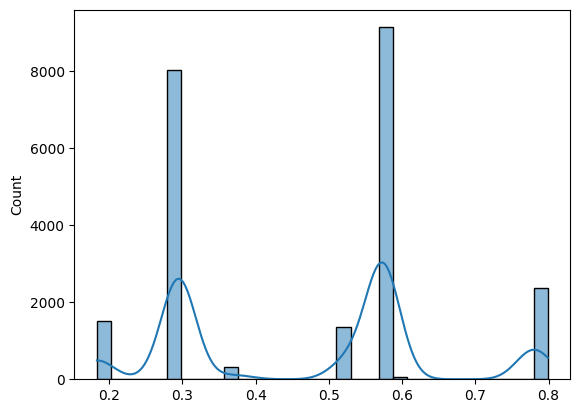

In [58]:
# Distribution plot of predicted probability
sns.histplot(x = np.reshape(y_train_pred_proba,
                            y_train.shape[0]),
             kde = True)

#### **Predict on Test Data**
---

In [59]:
# Rename the raw X_test for the future
raw_test = X_test

# Define X_test
X_test = woe_test.to_numpy()
X_test

array([[ 0.04744949,  0.31118024,  0.66539384, ...,  0.18456708,
         0.21135854,  0.02843558],
       [ 0.02610406, -0.86241784, -0.50616062, ..., -1.13753569,
         0.21135854, -0.07004346],
       [ 0.04744949,  1.02684385,  1.28961894, ...,  0.66343514,
        -0.7667414 ,  0.08763661],
       ...,
       [ 0.02610406,  0.02410913, -0.50616062, ..., -1.13753569,
         0.21135854, -0.07004346],
       [ 0.06896853, -0.86241784, -0.50616062, ...,  0.66343514,
         0.21135854,  0.08763661],
       [ 0.04744949,  0.31118024,  0.66539384, ..., -1.13753569,
         0.21135854,  0.08763661]])

In [60]:
# Check y_test
y_test = y_test.to_numpy()
y_test

array([1, 1, 0, ..., 1, 0, 0])

In [61]:
# Define X_test with best predictors
X_test_best = X_test[:, best_predictors]

# Predict class labels for sample in X_test.
y_test_pred = best_model.predict(X_test_best)
y_test_pred

array([0, 1, 0, ..., 1, 1, 0])

In [62]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.8124706985466479

Recall score from the test set is 0.812.

Check the distribution of the predicted probabilities.

In [63]:
# Predict the probability estimates
y_test_pred_proba = best_model.predict_proba(X_test_best)[:,[1]]
y_test_pred_proba

array([[0.29465897],
       [0.57314154],
       [0.3719252 ],
       ...,
       [0.57314154],
       [0.57314154],
       [0.29465897]])

<Axes: ylabel='Count'>

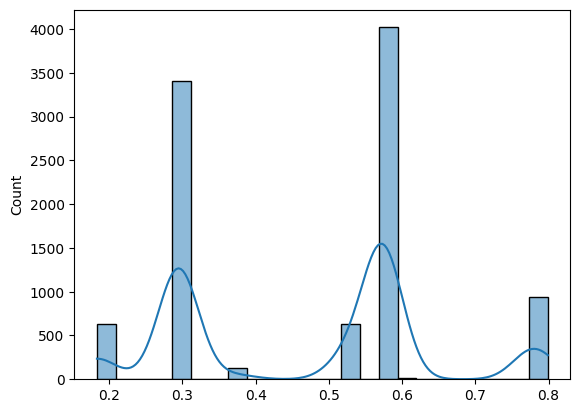

In [64]:
# Distribution plot of predicted probability
sns.histplot(x = np.reshape(y_test_pred_proba,
                            y_test.shape[0]),
             kde = True)

**Summary**:
- From model selection, we have a best logistic regression model that includes 2 predictors (`person_home_ownership` and `cb_person_default_on_file`).
- The sensitivity/recall score from the best model is 0.81 on the train set and test set, which means:
  - The model can predict about 81% of bad applicants correctly.
  - We still have a chance of about 19% to misclassify bads as goods.
- The best model may be questioned by other departments since the best model only contains 2 predictors.
  - Scorecards with too few characteristics are generally unable to withstand the test of time, as they are susceptible to minor changes in the applicant profile.
  - In business terms, scorecards should be developed to mimic the thought process of a seasoned, effective adjudicator or risk analyst. A good adjudicator will never look at just two or three things from an application form or account history to make a decision.

What can we do then?

- Regardless of the modeling technique used, we should produce a scorecard consisting of the optimal combination of characteristics, taking into account other issues such as:
  - Correlation between characteristics.
  - Final statistical strength of the scorecard.
  - Business sense.
  - Compliance with local regulations and laws.
  - Interpretability (causality) of characteristics from a business perspective—being able to explain in plain business language why that variable is strong and should be in the model.
  - Implementability from a technical perspective.
- The scorecard developer has several methods by which to influence the final shape of the model.
  - Forcing characteristics in, whereby characteristics deemed operationally necessary or “must have” are forced into the scorecard at the outset.
  - Manipulating regression to maximize the chances of certain characteristics entering the final model.


## **4.5 Model Adjustment**
---

Scorecards with too few characteristics are generally unable to withstand the test of time:
  - They are susceptible to minor changes in the applicant profile.
  - A good adjudicator will never look at just two characteristics from an application form to make a decision.

We will include all characteristics in the final model.
  - From the independence test, all characteristics are not independent of the response variable (probability of default).
  - Generally, a final scorecards consist of between 8 and 15 characteristics


In [65]:
best_predictors = forward_models['Predictors'].loc[len(predictors)]

# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

Extract the best model' parameter estimates.

In [66]:
best_model_intercept = pd.DataFrame({'Characteristic': 'Intercept',
                                     'Estimate': best_model.intercept_})
best_model_intercept

,Characteristic,Estimate
0,Intercept,-0.059245


In [67]:
best_model_params = raw_train.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Characteristic':  best_model_params,
                                 'Estimate':        np.reshape(best_model.coef_,
                                                               len(best_predictors))})

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0,
                               ignore_index = True)

best_model_summary

,Characteristic,Estimate
0,Intercept,-0.059245
1,person_home_ownership,-0.750532
2,cb_person_default_on_file,0.017190
3,person_age,-0.235627
4,cb_person_cred_hist_length,-0.366965
5,person_emp_length,-0.242632
6,loan_int_rate,0.007992
7,person_income,-0.977186
8,loan_amnt,-0.855652
9,loan_grade,-1.156428


#### **Predict on Train Data**
---

In [68]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([0, 0, 1, ..., 0, 1, 1])

In [69]:
# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.8002010050251256

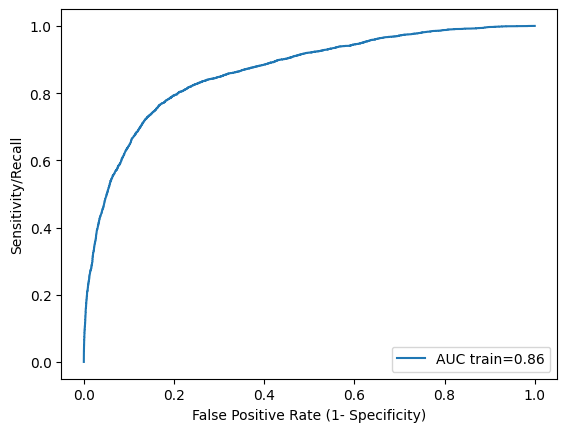

In [70]:
# Using method sklearn.metrics.roc_curve
from sklearn import metrics

# Predict probability of default on X_train
y_train_pred_proba = best_model.predict_proba(X_train_best)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr, tpr, threshold = metrics.roc_curve(y_true = y_train,
                                        y_score = y_train_pred_proba[:,1])

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc_train = metrics.roc_auc_score(y_true = y_train,
                                  y_score = y_train_pred_proba[:,1])
auc_train = round(auc_train, 2)

# Plot ROC and its AUC
plt.plot(fpr,
         tpr,
         label = "AUC train="+str(auc_train))

plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

In [71]:
# Install and import library to plot KS
import scikitplot as skplt

In [72]:
import scipy
print(scipy.__version__)

1.11.4


<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

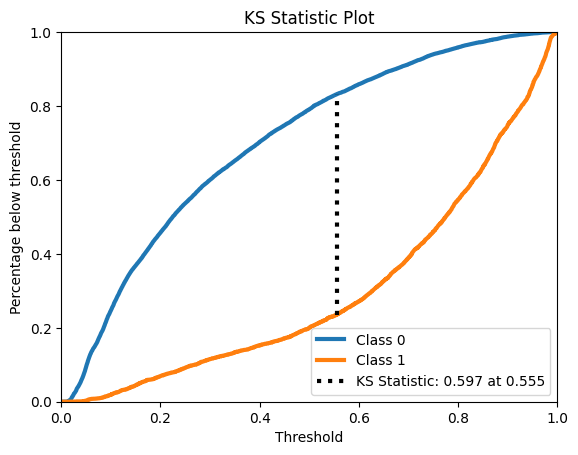

In [73]:
# Plot KS Statistic
skplt.metrics.plot_ks_statistic(y_train,
                                y_train_pred_proba)

#### **Predict on Test Data**
---

In [74]:
# Define X_test with best predictors
X_test_best = X_test[:, best_predictors]

# Predict class labels for sample in X_test.
y_test_pred = best_model.predict(X_test_best)
y_test_pred

array([1, 1, 0, ..., 1, 0, 1])

In [75]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.8045007032348804

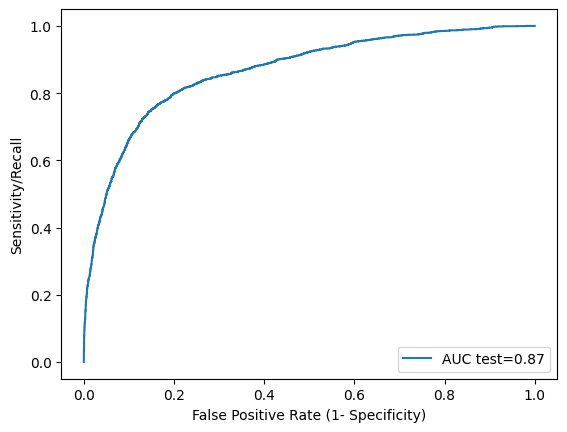

In [76]:
# Predict probability of default on X_test
y_test_pred_proba = best_model.predict_proba(X_test_best)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr_, tpr_, threshold_ = metrics.roc_curve(y_true = y_test,
                                           y_score = y_test_pred_proba[:,1])

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc_test = metrics.roc_auc_score(y_true = y_test,
                                 y_score = y_test_pred_proba[:,1])
auc_test = round(auc_test, 2)

# Plot ROC and its AUC
plt.plot(fpr_,
         tpr_,
         label = "AUC test="+str(auc_test))

plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

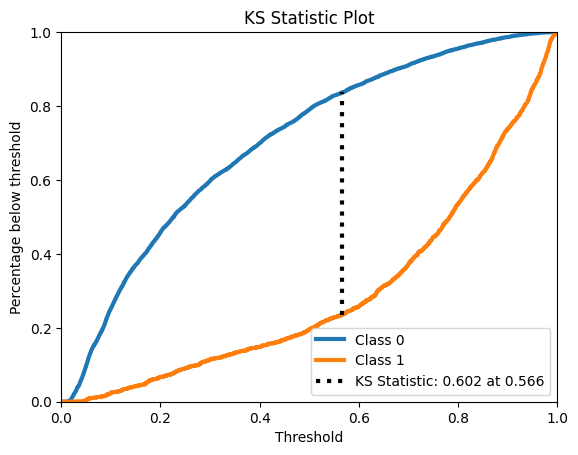

In [77]:
# Plot KS Statistic
skplt.metrics.plot_ks_statistic(y_test,
                                y_test_pred_proba)

- The sensitivity/recall score from the adjusted model is 0.80 on the train set and 0.805 on the test set.
- The AUC from the adjusted model is quite good; 0.86 on the train set and 0.87 on the test set.

The sensitivity/recall score difference between the adjusted model and the best model from the forward selection is trivial.

# **5. Scaling**
---

## **5.1 Create Scorecards**
---

Assign score to each attribute by specifying:
- Odds of good of 30:1 at 300 points score, and
- 20 PDO (points to double the odds of good).

Thus, we can calculate the offset and factor:
- $\text{Factor}=\text{PDO}/ \ln(2)$
- $\text{Offset} = \text{Score} − {\text{Factor} ∗ \ln (\text{Odds of good})}$

In [78]:
# Define Factor and Offset
factor = 20/np.log(2)
offset = 300-(factor*np.log(30))

print(f"Offset = {offset:.2f}")
print(f"Factor = {factor:.2f}")

Offset = 201.86
Factor = 28.85


Therefore, the score point for each attribute $j$ in each characteristic $i$:
$$
\frac{\text{Offset}}{n} - \text{Factor} \times \left (\frac{\beta_0}{n}  + \beta_i \times \text{WOE}_j \right )
$$


In [79]:
# Define n = number of characteristics
n = len(best_predictors)

# Define b0
b0 = best_model.intercept_[0]

print(f"n = {n}")
print(f"b0 = {b0:.4f}")

n = 11
b0 = -0.0592


Next, assign the score point to each attribute.

In [80]:
# Adjust characteristic name in best_model_summary_table
for col in best_model_summary['Characteristic']:
  if col in num_columns:
    bin_col = col + '_bin'
  else:
    bin_col = col
  best_model_summary.replace(col, bin_col, inplace = True)


# Merge tables to get beta_i for each characteristic
scorecards = pd.merge(left = WOE_table,
                      right = best_model_summary,
                      how = 'left',
                      on = ['Characteristic'])

scorecards.head()

,Characteristic,Attribute,WOE,Estimate
0,person_age_bin,"(19.999, 23.0]",-0.119722,-0.235627
1,person_age_bin,"(23.0, 26.0]",0.026104,-0.235627
2,person_age_bin,"(26.0, 30.0]",0.047449,-0.235627
3,person_age_bin,"(30.0, 144.0]",0.068969,-0.235627
4,person_income_bin,"(3999.999, 38524.75]",-0.862418,-0.977186


In [81]:
# Define beta and WOE
beta = scorecards['Estimate']
WOE = scorecards['WOE']

# Calculate the score point for each attribute
scorecards['Points'] = (offset/n) - factor*((b0/n) + (beta*WOE))
scorecards['Points'] = scorecards['Points'].astype('int')

scorecards

,Characteristic,Attribute,WOE,Estimate,Points
0,person_age_bin,"(19.999, 23.0]",-0.119722,-0.235627,17
1,person_age_bin,"(23.0, 26.0]",0.026104,-0.235627,18
2,person_age_bin,"(26.0, 30.0]",0.047449,-0.235627,18
3,person_age_bin,"(30.0, 144.0]",0.068969,-0.235627,18
4,person_income_bin,"(3999.999, 38524.75]",-0.862418,-0.977186,-5
5,person_income_bin,"(38524.75, 55000.0]",0.024109,-0.977186,19
6,person_income_bin,"(55000.0, 79635.0]",0.311180,-0.977186,27
7,person_income_bin,"(79635.0, 6000000.0]",1.026844,-0.977186,47
8,person_emp_length_bin,"(-0.001, 2.0]",-0.284110,-0.242632,16
9,person_emp_length_bin,"(2.0, 4.0]",0.065751,-0.242632,18


In [82]:
# Calculate the min and max points for each characteristic
grouped_char = scorecards.groupby('Characteristic')
grouped_points = grouped_char['Points'].agg(['min', 'max'])
grouped_points

,min,max
Characteristic,,
cb_person_cred_hist_length_bin,17,19
cb_person_default_on_file,18,18
loan_amnt_bin,8,26
loan_grade,-146,48
loan_int_rate_bin,18,18
loan_intent,6,35
loan_percent_income_bin,-6,34
person_age_bin,17,18
person_emp_length_bin,15,20


In [83]:
# Calculate the min and max score from the scorecards
total_points = grouped_points.sum()
min_score = total_points['min']
max_score = total_points['max']

print(f"The lowest credit score = {min_score}")
print(f"The highest credit score = {max_score}")

The lowest credit score = -53
The highest credit score = 329


## **5.2 Predict Credit Score**
---

To predict a credit score from an input, we need to:
- Transform the raw input value into the score point
- Calculate the total score points

Therefore, we will:
- Generate the points map dictionary for each attribute
- Transform the raw input value into the score point according to its attribute

In [84]:
# Function to generate the points map dictionary
def get_points_map_dict(scorecards):

    # Initialize the dictionary
    points_map_dict = {}
    points_map_dict['Missing'] = {}
    unique_char = set(scorecards['Characteristic'])
    for char in unique_char:
        # Get the Attribute & WOE info for each characteristics
        current_data = (scorecards
                            [scorecards['Characteristic']==char]     # Filter based on characteristic
                            [['Attribute', 'Points']])               # Then select the attribute & WOE

        # Get the mapping
        points_map_dict[char] = {}
        for idx in current_data.index:
            attribute = current_data.loc[idx, 'Attribute']
            points = current_data.loc[idx, 'Points']

            if attribute == 'Missing':
                points_map_dict['Missing'][char] = points
            else:
                points_map_dict[char][attribute] = points
                points_map_dict['Missing'][char] = np.nan

    return points_map_dict


In [85]:
# Generate the points map dict
points_map_dict = get_points_map_dict(scorecards = scorecards)
points_map_dict

{'Missing': {'person_emp_length_bin': 15,
  'loan_int_rate_bin': 18,
  'loan_intent': nan,
  'person_age_bin': nan,
  'cb_person_default_on_file': nan,
  'loan_amnt_bin': nan,
  'cb_person_cred_hist_length_bin': nan,
  'person_home_ownership': nan,
  'loan_percent_income_bin': nan,
  'loan_grade': nan,
  'person_income_bin': nan},
 'person_emp_length_bin': {Interval(-0.001, 2.0, closed='right'): 16,
  Interval(2.0, 4.0, closed='right'): 18,
  Interval(4.0, 7.0, closed='right'): 19,
  Interval(7.0, 123.0, closed='right'): 20},
 'loan_int_rate_bin': {Interval(5.419, 7.9, closed='right'): 18,
  Interval(7.9, 10.99, closed='right'): 18,
  Interval(10.99, 13.47, closed='right'): 18,
  Interval(13.47, 22.48, closed='right'): 18},
 'loan_intent': {'DEBTCONSOLIDATION': 6,
  'EDUCATION': 28,
  'HOMEIMPROVEMENT': 10,
  'MEDICAL': 8,
  'PERSONAL': 22,
  'VENTURE': 35},
 'person_age_bin': {Interval(19.999, 23.0, closed='right'): 17,
  Interval(23.0, 26.0, closed='right'): 18,
  Interval(26.0, 30.0

Assume we have a raw input:

In [86]:
input = {
    'person_age_bin': 23,
    'person_income_bin': 55000,
    'person_emp_length_bin': 2,
    'loan_amnt_bin': 9000,
    'loan_int_rate_bin': 8,
    'loan_percent_income_bin': 0.21,
    'cb_person_cred_hist_length_bin': 4,
    'person_home_ownership': 'RENT',
    'loan_intent': 'MEDICAL',
    'loan_grade': 'B',
    'cb_person_default_on_file': 'N'
}

First, create the function to transform the raw input values into score points.

In [87]:
def transform_points(raw_data, points_map_dict, num_cols):

    points_data = raw_data.copy()

    # Map the data
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].map(points_map_dict[map_col])

    # Map the data if there is a missing value or out of range value
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].fillna(value=points_map_dict['Missing'][map_col])

    return points_data

In [88]:
input_table = pd.DataFrame(input, index=[0])
input_points = transform_points(raw_data = input_table,
                                points_map_dict = points_map_dict,
                                num_cols = num_columns)

input_points

,person_age_bin,person_income_bin,person_emp_length_bin,loan_amnt_bin,loan_int_rate_bin,loan_percent_income_bin,cb_person_cred_hist_length_bin,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,17,19,16,21,18,22,18,7,8,29,18


Now we can calculate the credit score.

In [89]:
# Function to predict the credit score
def predict_score(raw_data, cutoff_score):

    # Transform raw input values into score points
    points = transform_points(raw_data = raw_data,
                              points_map_dict = points_map_dict,
                              num_cols = num_columns)

    # Caculate the score as the total points
    score = int(points.iloc[0].sum())

    print(f"Credit Score : ", score)

    if score > cutoff_score:
        print("Recommendation : APPROVE")
    else:
        print("Recommendation : REJECT")

    return score

In [90]:
input_score = predict_score(raw_data = input_table,
                            cutoff_score = 150)

Credit Score :  193
Recommendation : APPROVE


### **Predict Score on Train Set**
---

In [91]:
# Transform the raw values in X_train into points
train_points = transform_points(raw_data = raw_train,
                                points_map_dict = points_map_dict,
                                num_cols = num_columns)

train_points.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
11491,18,27,7,16.0,6,29,21,18.0,22,18,17
3890,17,19,32,18.0,28,21,20,18.0,33,18,18
17344,18,-5,7,16.0,6,48,21,18.0,-6,18,17
13023,18,47,7,16.0,10,29,21,18.0,33,18,17
29565,18,-5,7,18.0,8,29,8,18.0,-6,18,18


In [92]:
# Calculate the total score
train_points['Score'] = train_points.sum(axis=1).astype(int)

train_points[['person_age', 'Score']].head()

,person_age,Score
11491,18,199
3890,17,242
17344,18,158
13023,18,234
29565,18,131


<Axes: xlabel='Score', ylabel='Count'>

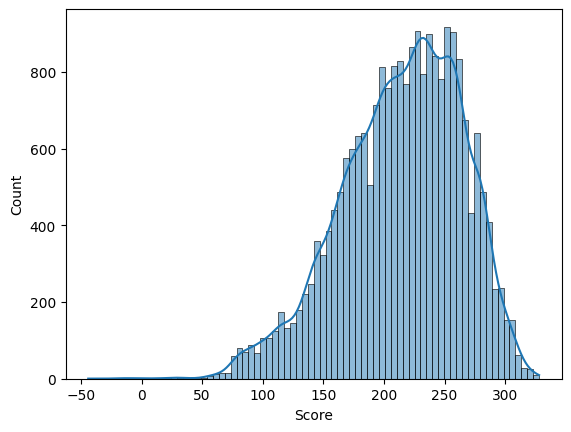

In [93]:
# Distribution plot of predicted score
sns.histplot(x = train_points['Score'],
             kde = True)

### **Predict Score on Test Set**
---

In [94]:
# Transform the raw values in X_train into points
test_points = transform_points(raw_data = raw_test,
                               points_map_dict = points_map_dict,
                               num_cols = num_columns)

test_points.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
28004,18,27,32,18.0,8,-36,21,18.0,22,18,18
15942,18,-5,7,15.0,28,48,20,18.0,-6,18,17
26343,18,47,46,19.0,35,21,21,18.0,33,18,19
16374,17,27,32,16.0,22,21,26,18.0,33,18,18
27301,18,47,32,20.0,35,48,8,18.0,33,18,18


In [95]:
# Calculate the total score
test_points['Score'] = test_points.sum(axis=1).astype(int)

test_points[['person_age', 'Score']].head()

,person_age,Score
28004,18,164
15942,18,178
26343,18,295
16374,17,248
27301,18,295


<Axes: xlabel='Score', ylabel='Count'>

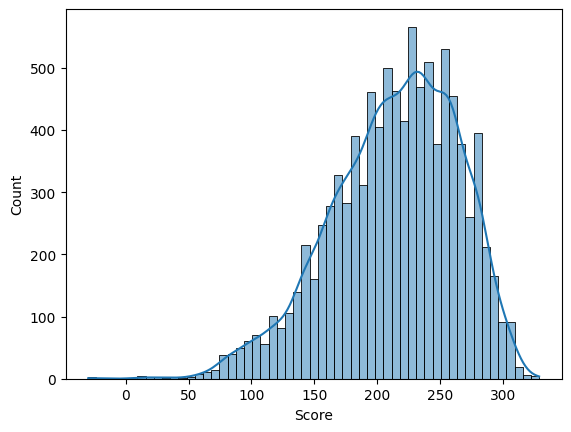

In [96]:
# Distribution plot of predicted score
sns.histplot(x = test_points['Score'],
             kde = True)

## **5.3 Setting Cutoff**
---

To set the cutoff score, we need information of:

- Expected approval rate from:
  - Most current applicant distribution — most recent month/quarter.

- Expected bad rate from:
  - Development sample, or
  - Most recent sample — use performance window for the scorecard.

Since we don't hace the most recent credit applications data, we will:
- Estimate the expected approval rate from the test set.
- Estimate the expected bad rate from the train set.


### **Estimate the Expected Approval Rate**
---

In [97]:
cutoff_list = []
approval_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  approve_counts = len(train_points[train_points['Score'] >= cutoff])
  n_sample = len(train_points)

  approval_rate = approve_counts/n_sample

  approval_rate_list.append(approval_rate)

approval_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                                    'Expected Approval Rate' : approval_rate_list})

approval_rate_table

,Cutoff,Expected Approval Rate
0,-53,1.000000
1,-52,1.000000
2,-51,1.000000
3,-50,1.000000
4,-49,1.000000
...,...,...
377,324,0.000438
378,325,0.000351
379,326,0.000263
380,327,0.000175


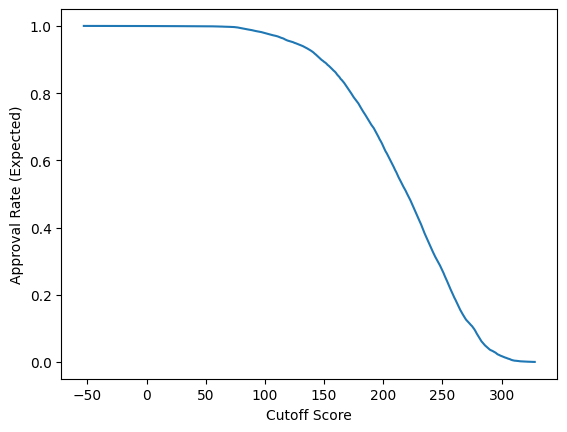

In [98]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

plt.xlabel('Cutoff Score')
plt.ylabel('Approval Rate (Expected)')
plt.show()

### **Estimate the Expected Bad Rate**
---

In [99]:
cutoff_list = []
bad_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  bad_counts = len(train_points[train_points['Score'] < cutoff])
  n_sample = len(train_points)

  bad_rate = bad_counts/n_sample

  bad_rate_list.append(bad_rate)

bad_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                               'Expected Bad Rate' : bad_rate_list})

bad_rate_table

,Cutoff,Expected Bad Rate
0,-53,0.000000
1,-52,0.000000
2,-51,0.000000
3,-50,0.000000
4,-49,0.000000
...,...,...
377,324,0.999562
378,325,0.999649
379,326,0.999737
380,327,0.999825


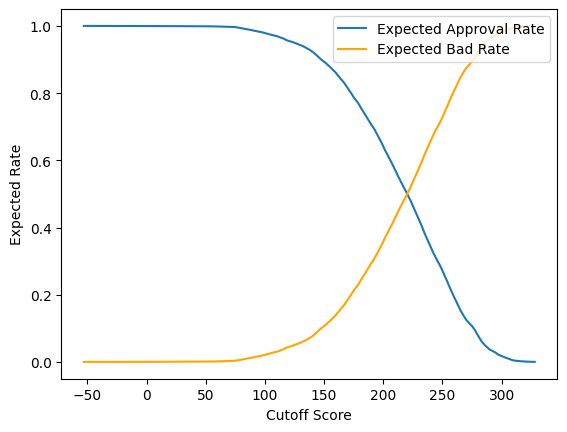

In [100]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

# Plot the expected bad rate
plt.plot(bad_rate_table['Cutoff'],
         bad_rate_table['Expected Bad Rate'],
         label = "Expected Bad Rate",
         color = 'orange')

plt.ylabel("Expected Rate")
plt.xlabel("Cutoff Score")
plt.legend(loc = 1)
plt.show()

Which cutoff will we choose?